In [1]:
import random

from keyname import keyname as kn
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from slugify import slugify
import statsmodels.api as sm
import statsmodels.formula.api as smf
from teeplot import teeplot as tp
import itertools as it
import matplotlib.patheffects as pe


In [2]:
np.random.seed(1)
random.seed(1)


In [3]:
from conduitpylib.viz import _get_defaults as cfg

from conduitpylib.viz import beleaguerment_facetplot, beleaguerment_regplot

from conduitpylib.wrangle import (
    retrieve_and_prepare_delta_dataframes,
    wrangle_instrumentation_longform,
)


<Figure size 72x72 with 0 Axes>

In [4]:
nbm.print_metadata()


context: ci
hostname: 545621fc89b4
interpreter: 3.8.10 (default, Nov 22 2023, 10:22:35)  [GCC 9.4.0]
nbcellexec: 4
nbname: None
nbpath: None
revision: null
session: dc5ebc51-0c8b-48df-8624-48151acabde6
timestamp: 2023-11-30T19:17:08Z00:00


IPython==7.16.1
keyname==0.5.6
yaml==5.4.1
matplotlib==3.5.2
nbmetalog==0.2.6
numpy==1.23.5
pandas==1.1.2
scipy==1.5.4
seaborn==0.13.0
statsmodels==0.12.2
teeplot==0.6.1
re==2.2.1
ipython_genutils==0.2.0
logging==0.5.1.2
zmq==22.2.1
json==2.0.9
six==1.15.0
ipykernel==5.5.3


# Get Data


In [5]:
def apply(df: pd.DataFrame) -> pd.DataFrame:
    row_distiller = lambda row: {
        k: v for k, v in row.items() if k in ("Num Threads", "Num Processes")
    }
    df["Concurrency"] = df.apply(
        lambda row: {
            frozenset(
                {"Num Threads": 1, "Num Processes": 2}.items()
            ): "Multiprocessing",
            frozenset(
                {"Num Threads": 2, "Num Processes": 1}.items()
            ): "Multithreading",
        }[frozenset(row_distiller(row).items())],
        axis=1,
    )
    return df


longitudinal_df, snapshot_df = retrieve_and_prepare_delta_dataframes(
    df_inlet_url="https://osf.io/pe987/download",
    df_outlet_url="https://osf.io/vrxmq/download",
    apply=apply,
    treatment_column="Concurrency",
)


a: df_inlet
digest: b1e38cc19a817163d95ddb8a6e5e3314081b76a302f8d0b49a3a1b1c7cb08be2
num cols: 42
num cols all na: 2
num cols any na: 42
num na: 822
num rows: 391
num rows all na: 1
num rows any na: 391
size: 306K

a: df_outlet
digest: e034acf2fb0d1ef186c6c863eea9268f5779c850ac951531bfe978f1fd121b2a
num cols: 68
num cols all na: 6
num cols any na: 68
num na: 2408
num rows: 391
num rows all na: 1
num rows any na: 391
size: 386K

df_inlet has 1 na rows, dropping them
df_outlet has 1 na rows, dropping them


# Compare Finalized and Rolling Measures


teeplots/./hue=instrumentation+treatment=multiprocessing+viz=beleaguerment-facetplot+x=messages-received-per-second+y=messages-sent-per-second+ext=.pdf
skipping teeplots/./hue=instrumentation+treatment=multiprocessing+viz=beleaguerment-facetplot+x=messages-received-per-second+y=messages-sent-per-second+ext=.png
teeplots/./hue=instrumentation+treatment=multithreading+viz=beleaguerment-facetplot+x=messages-received-per-second+y=messages-sent-per-second+ext=.pdf
skipping teeplots/./hue=instrumentation+treatment=multithreading+viz=beleaguerment-facetplot+x=messages-received-per-second+y=messages-sent-per-second+ext=.png


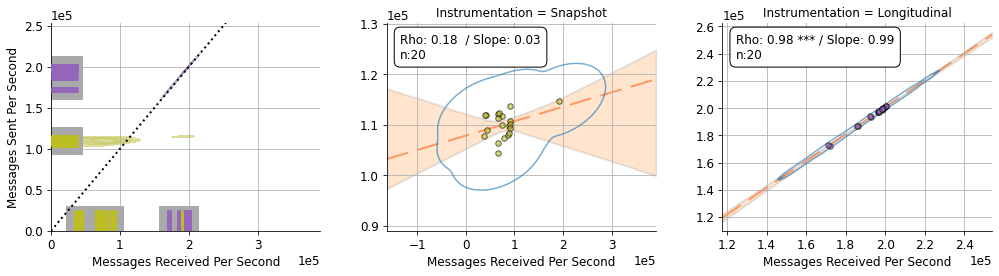

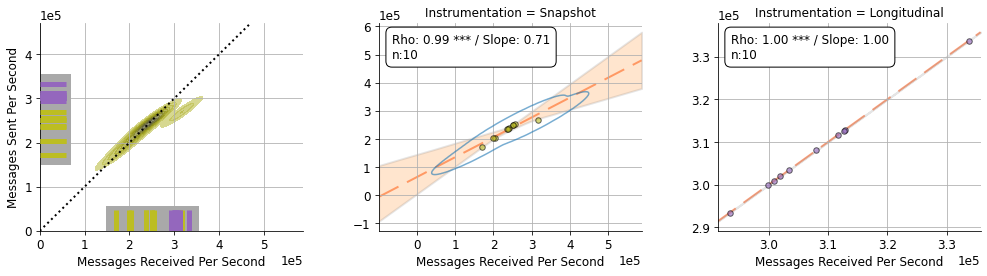

In [6]:
data = wrangle_instrumentation_longform(
    longitudinal_df=longitudinal_df,
    snapshot_df=snapshot_df,
)

for treatment, group in data.groupby("Concurrency"):
    group_df = group.reset_index()
    tp.tee(
        beleaguerment_facetplot,
        data=group_df,
        x="Messages Received Per Second",
        y="Messages Sent Per Second",
        hue="Instrumentation",
        annotation_kwargs=dict(
            xy=(0.05, 0.95),
        ),
        scatter_kwargs=dict(
            alpha=0.6,
            s=30,
            zorder=999,
        ),
        kde_kwargs=dict(
            cut=10,
            kde_thresh=1e-3,
        ),
        regline_kwargs=dict(
            linewidth=6,
            zorder=-9999,
        ),
        teeplot_outattrs={
            "treatment": slugify(treatment),
        },
    )
